# [ VAE ] OOD Detection using FSS

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.append(os.getcwd() + '/core')
sys.path.append(os.getcwd() + '/core/train_GLOW') 
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

import core.config as config
from core.model_loader import load_pretrained_VAE
from core.data_loader import TRAIN_loader, TEST_loader
from core.custom_loss import KL_div, VAE_loss_pixel
from core.fisher_utils_VAE import Calculate_fisher_VAE, Calculate_score_VAE, AUTO_VAE, Calculate_fisher_VAE_ekfac, Calculate_score_VAE_ekfac
from core.visualize import plot_hist, AUROC, plot_scores_all_layers

# fix a random seed
random.seed(2021)
np.random.seed(2021)
torch.manual_seed(2021)

# Define Global Variables & Initialize

In [2]:
# FISHER_invs : Fisher inverse matrices from calculating Fisher score (w.r.t. train-dist)
FISHERs = {'cifar10': {}, 'fmnist': {}}
         
# NORMalize_FACtors : Normalizing Factor (w.r.t. train-dist)
NORM_FACs = {'cifar10': {}, 'fmnist': {}}
             
# SCOREs : (Scalars) Scores from calculating Fisher score (w.r.t. target-dist)
SCOREs = {'cifar10': {}, 'fmnist': {}}


# VAE - CIFAR10 & FMNIST

## [1] Load the model & Parameter Selection

In [3]:
opt = config.VAE_fmnist
netE, netG = load_pretrained_VAE(option=opt.train_dist, ngf=32, nz=100, beta=1, augment='hflip', epoch=100)
netE.eval()
netG.eval()

params = {
    #'Emain0_w': netE.main[0].weight,
    #'Emain1_w': netE.main[1].weight,
    #'Emain1_b': netE.main[1].bias,
    #'Emain3_w': netE.main[3].weight,
    #'Emain4_w': netE.main[4].weight,
    #'Emain4_b': netE.main[4].bias,
    #'Emain6_w': netE.main[6].weight,
    #'Emain7_w': netE.main[7].weight,
    #'Emain7_b': netE.main[7].bias,
    'Econv1_w': netE.conv1.weight,
    #'Econv1_b': netE.conv1.bias,
    #'Econv2_w': netE.conv2.weight,
    #'Econv2_b': netE.conv2.bias,
    #'Gmain0_w': netG.main[0].weight,
    #'Gmain1_w': netG.main[1].weight,
    #'Gmain1_b': netG.main[1].bias,
    #'Gmain3_w': netG.main[3].weight,
    #'Gmain4_w': netG.main[4].weight,
    #'Gmain4_b': netG.main[4].bias,
    #'Gmain6_w': netG.main[6].weight,
    #'Gmain7_w': netG.main[7].weight,
    #'Gmain7_b': netG.main[7].bias,
    #'Gmain9_w': netG.main[9].weight,
}


## [2] Compute ROSE via EKFAC

In [17]:
loader = TEST_loader('fmnist', 'celeba')
for i, x in enumerate(loader):
    try:
        x, _ = x
    except:
        pass
    plt.figure()
    plt.imshow(x[0].permute(1, 2, 0))
    plt.show()
    break

<class 'PIL.Image.Image'>


TypeError: img should be PIL Image. Got <class 'torch.Tensor'>

Calculate A, B:   0%|          | 0/60000 [00:00<?, ?step/s]/home/shinypond/anaconda3/envs/ycy/lib/python3.7/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Calculate Score VAE:  50%|████▉     | 4999/10000 [00:24<00:24, 205.15step/s]


Average Inference Time : 0.0048777583999999995 seconds
Average #Images Processed : 205.01220396647773 Images


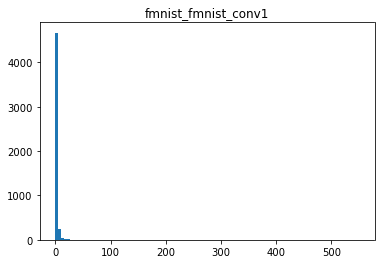

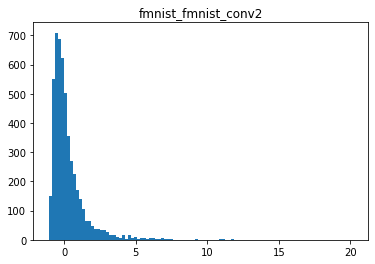

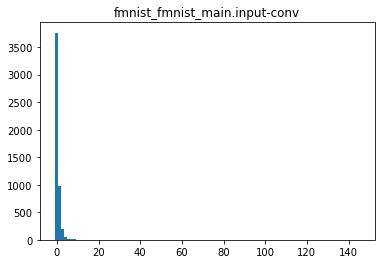

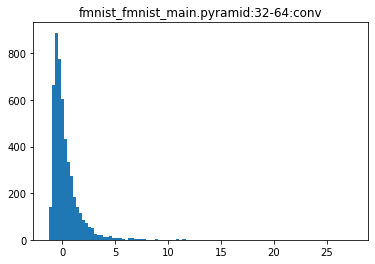

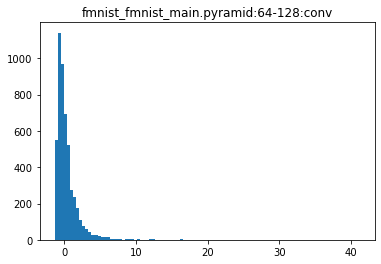

Using downloaded and verified file: ../data/test_32x32.mat


Calculate Score VAE:   0%|          | 0/26032 [00:00<?, ?step/s]


TypeError: img should be PIL Image. Got <class 'torch.Tensor'>

In [4]:
method = 'ekfac(max)'
auroc = {}
SCOREs = {}
U_A, U_B, S, mean, std = Calculate_fisher_VAE_ekfac(netE, netG, params, opt, max_iter=10000)

for ood in opt.ood_list:
    score = Calculate_score_VAE_ekfac(netE, netG, params, opt, U_A, U_B, S, ood, max_iter=5000)
    temp = []
    for name in score.keys():
        a = np.array(score[name])
        #for name2, module in netE.named_modules():
        #    if name == name2:
        #        k = 0
        #        for param in module.parameters():
        #            k += np.array(param.shape).prod()
        a = (a - mean[name]) / std[name]  
        temp.append(a) 
        plt.figure()
        plt.title(f'{opt.train_dist}_{ood}_{name}')
        plt.hist(a, bins=100)
        plt.show()
    score = np.max(np.concatenate(temp, 1), 1)
    SCOREs[ood] = score
    args = [SCOREs[opt.train_dist], SCOREs[ood]]
    labels = [opt.train_dist, ood]
    auroc[ood] = AUROC(*args, labels=labels, verbose=False)
auroc
    

## [3] Save the result score (see the directory npy/ROSE)

In [7]:
for ood in opt.ood_list:
    score_path = f'./npy/ROSE/VAE_{opt.train_dist}/{opt.train_dist}_{ood}_{method}.npy'
    np.save(score_path, SCOREs[ood])

## [4] View scores for each layer

In [8]:
# Just show scores
# plot_scores_all_layers(train_dist, params, SCOREs, opt, save=True)


## [5] Check the reconstruction ability of VAE

Files already downloaded and verified


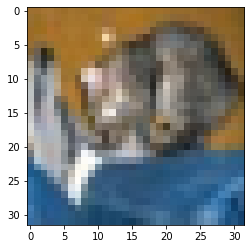

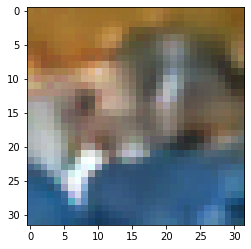

In [9]:
# Check the ability of reconstruction
loader = TEST_loader('cifar10', 'cifar10')
for i,(x,_) in enumerate(loader):
    z, mu, logvar = netE(x.cuda())
    y = netG(z)
    plt.figure()
    plt.imshow(x[0].permute(1, 2, 0).detach().cpu())
    plt.show()
    plt.figure()
    plt.imshow(torch.argmax(y, 4)[0].permute(1, 2, 0).detach().cpu())
    plt.show()
    if i == 0:
        break